# Recurring Neural Network

A recurring neural network is essentially just a FNN which allows one set of hidden layer of neurons to pass information to the next iteration's FNN, making a sort of time-dependance.

Given that the code is extremely similar compared with FNN, the same examples will be used.

Nb: In all the examples, the batch processing method as described in the FNN notebook will be used.

## 1 Hidden Layer RNN

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


batch_size = 600
n_iters = 100000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
         h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()


learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  


# Number of steps to unroll
seq_dim = 28  
accuracy_history = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 100 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Resize images
                images = images.view(-1, seq_dim, input_dim)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted.type(torch.FloatTensor).cpu() ==labels.type(torch.FloatTensor)).sum()
            
            accuracy = 100. * correct.item() / total
            accuracy_history.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 26590298.94it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 168380.77it/s]           


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz





1654784it [00:00, 6985837.58it/s]                           

8192it [00:00, 174379.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz

Processing...
Done!
Iteration: 100. Loss: 2.3025753498077393. Accuracy: 11.38
Iteration: 200. Loss: 2.301771640777588. Accuracy: 11.37
Iteration: 300. Loss: 2.303159236907959. Accuracy: 11.37
Iteration: 400. Loss: 2.299004316329956. Accuracy: 11.36
Iteration: 500. Loss: 2.3042099475860596. Accuracy: 11.35
Iteration: 600. Loss: 2.3000290393829346. Accuracy: 11.35
Iteration: 700. Loss: 2.2990119457244873. Accuracy: 11.35
Iteration: 800. Loss: 2.295647621154785. Accuracy: 11.36
Iteration: 900. Loss: 2.2996833324432373. Accuracy: 11.41
Iteration: 1000. Loss: 2.29301381111145. Accuracy: 11.58
Iteration: 1100. Loss: 2.2975645065307617. Accuracy: 12.55
Iteration: 1200. Loss: 2.2887983322143555. Accuracy: 14.24
Iteration: 1300. Loss: 2.2896084785461426. Accuracy: 16.06
Iteration: 1400. Loss: 2.2916147708892822. Accuracy: 17.83
Iteration: 1500. Loss: 2.288755416870117. Accuracy: 19.02


Next, we try to plot the accuracy history just like before.

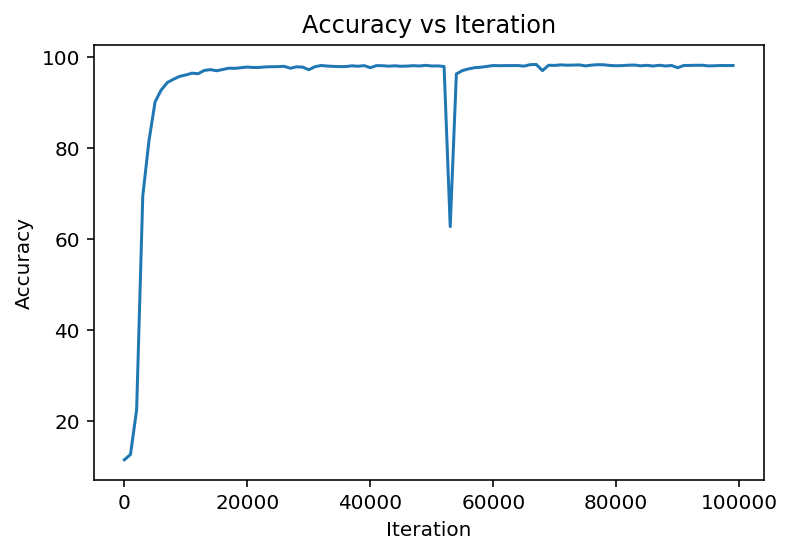

In [2]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
s = interpolate.InterpolatedUnivariateSpline(range(len(accuracy_history)), accuracy_history)
xnew = np.arange(0, 1000, 10)
ynew=s(xnew)

plt.plot(100*xnew, ynew)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title('Accuracy vs Iteration')
plt.show()

## 3 Hidden Layer RNN

Just like before, we now expand our RNN to 3 hidden layers.

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


batch_size = 600
n_iters = 100000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :]) 
        return out

input_dim = 28
hidden_dim = 100
layer_dim = 3 # The only change is the number of layers
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)


criterion = nn.CrossEntropyLoss()


learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

seq_dim = 28  
accuracy_history = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        
        iter += 1
        
        if iter % 100 == 0:
            model.eval()
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, seq_dim, input_dim)

                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                correct += (predicted.type(torch.FloatTensor).cpu() ==labels.type(torch.FloatTensor)).sum()
            
            accuracy = 100. * correct.item() / total
            accuracy_history.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 100. Loss: 2.3023786544799805. Accuracy: 11.35
Iteration: 200. Loss: 2.302102565765381. Accuracy: 11.35
Iteration: 300. Loss: 2.300503969192505. Accuracy: 11.35
Iteration: 400. Loss: 2.301264524459839. Accuracy: 11.35
Iteration: 500. Loss: 2.300394296646118. Accuracy: 11.35
Iteration: 600. Loss: 2.298257350921631. Accuracy: 11.35
Iteration: 700. Loss: 2.2955527305603027. Accuracy: 11.35
Iteration: 800. Loss: 2.2962586879730225. Accuracy: 11.35
Iteration: 900. Loss: 2.2964980602264404. Accuracy: 11.35
Iteration: 1000. Loss: 2.297180652618408. Accuracy: 11.39
Iteration: 1100. Loss: 2.296973943710327. Accuracy: 11.7
Iteration: 1200. Loss: 2.292105197906494. Accuracy: 13.32
Iteration: 1300. Loss: 2.2922515869140625. Accuracy: 15.61
Iteration: 1400. Loss: 2.2833001613616943. Accuracy: 17.84
Iteration: 1500. Loss: 2.2796249389648438. Accuracy: 19.21
Iteration: 1600. Loss: 2.2611258029937744. Accuracy: 19.69
Iteration: 1700. Loss: 2.2489681243896484. Accuracy: 19.08
Iteration: 1800

Once more, we plot the loss of the network.

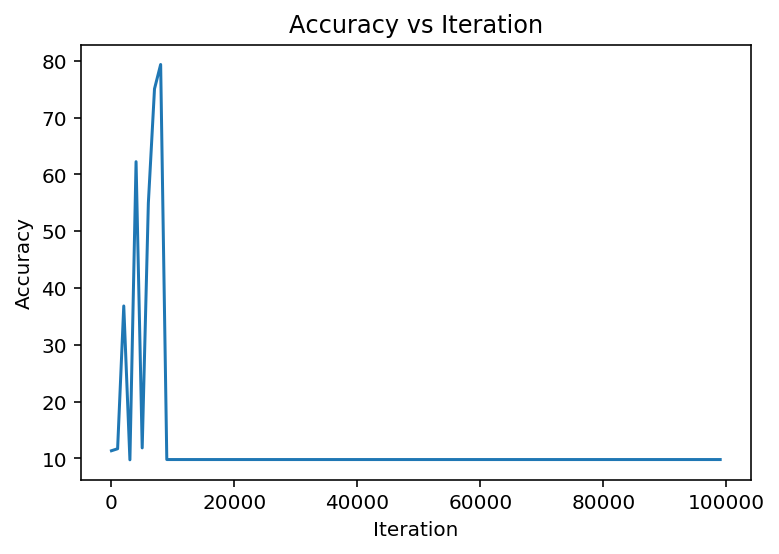

In [4]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
s = interpolate.InterpolatedUnivariateSpline(range(len(accuracy_history)), accuracy_history)
xnew = np.arange(0, 1000, 10)
ynew=s(xnew)

plt.plot(100*xnew, ynew)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title('Accuracy vs Iteration')
plt.show()